# Model understanding and interpretability

In this colab, we will 
- Will learn how to interpret model results and reason about the features
- Visualize the model results


In [1]:
import time

# We will use some np and pandas for dealing with input data.
import numpy as np
import pandas as pd
# And of course, we need tensorflow.
import tensorflow as tf

from matplotlib import pyplot as plt
from IPython.display import clear_output

In [2]:
tf.__version__

'1.13.1'

Below we demonstrate both *local* and *global* model interpretability for gradient boosted trees. 

Local interpretability refers to an understanding of a model’s predictions at the individual example level, while global interpretability refers to an understanding of the model as a whole.

For local interpretability, we show how to create and visualize per-instance contributions using the technique outlined in [Palczewska et al](https://arxiv.org/pdf/1312.1121.pdf) and by Saabas in [Interpreting Random Forests](http://blog.datadive.net/interpreting-random-forests/) (this method is also available in scikit-learn for Random Forests in the [`treeinterpreter`](https://github.com/andosa/treeinterpreter) package). To distinguish this from feature importances, we refer to these values as directional feature contributions (DFCs).

For global interpretability we show how to retrieve and visualize gain-based feature importances, [permutation feature importances](https://www.stat.berkeley.edu/~breiman/randomforest2001.pdf) and also show aggregated DFCs.

# Setup
## Load dataset
We will be using the titanic dataset, where the goal is to predict passenger survival given characteristiscs such as gender, age, class, etc.

In [3]:
tf.logging.set_verbosity(tf.logging.ERROR)
tf.set_random_seed(123)

# Load dataset.
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

# Feature columns.
fcol = tf.feature_column
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

def one_hot_cat_column(feature_name, vocab):
  return fcol.indicator_column(
      fcol.categorical_column_with_vocabulary_list(feature_name,
                                                 vocab))
fc = []
for feature_name in CATEGORICAL_COLUMNS:
  # Need to one-hot encode categorical features.
  vocabulary = dftrain[feature_name].unique()
  fc.append(one_hot_cat_column(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  fc.append(fcol.numeric_column(feature_name,
                                dtype=tf.float32))

# Input functions.
def make_input_fn(X, y, n_epochs=None):
  def input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((X.to_dict(orient='list'), y))
    # For training, cycle thru dataset as many times as need (n_epochs=None).
    dataset = (dataset
      .repeat(n_epochs)
      .batch(len(y)))  # Use entire dataset since this is such a small dataset.
    return dataset
  return input_fn

# Training and evaluation input functions.
train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, n_epochs=1)

# Interpret model

## Local interpretability
Output directional feature contributions (DFCs) to explain individual predictions, using the approach outlined in [Palczewska et al](https://arxiv.org/pdf/1312.1121.pdf) and by Saabas in [Interpreting Random Forests](http://blog.datadive.net/interpreting-random-forests/). The DFCs are generated with:

`pred_dicts = list(est.experimental_predict_with_explanations(pred_input_fn))`

In [4]:
params = {
  'n_trees': 50,
  'max_depth': 3,
  'n_batches_per_layer': 1,
  # You must enable center_bias = True to get DFCs. This will force the model to
  # make an initial prediction before using any features (e.g. use the mean of
  # the training labels for regression or log odds for classification when
  # using cross entropy loss).
  'center_bias': True
}

est = tf.estimator.BoostedTreesClassifier(fc, **params)
# Train model.
est.train(train_input_fn)

# Evaluation.
results = est.evaluate(eval_input_fn)
clear_output()
pd.Series(results).to_frame()

,0
accuracy,0.799242
accuracy_baseline,0.625000
auc,0.865289
auc_precision_recall,0.849765
average_loss,0.425263
global_step,153.000000
label/mean,0.375000
loss,0.425263
precision,0.739583
prediction/mean,0.388109


## Local interpretability
Next you will output the directional feature contributions (DFCs) to explain individual predictions using the approach outlined in [Palczewska et al](https://arxiv.org/pdf/1312.1121.pdf) and by Saabas in [Interpreting Random Forests](http://blog.datadive.net/interpreting-random-forests/) (this method is also available in scikit-learn for Random Forests in the [`treeinterpreter`](https://github.com/andosa/treeinterpreter) package). The DFCs are generated with:

`pred_dicts = list(est.experimental_predict_with_explanations(pred_input_fn))`

(Note: The method is named experimental as we may modify the API before dropping the experimental prefix.)

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns_colors = sns.color_palette('colorblind')

In [6]:
pred_dicts = list(est.experimental_predict_with_explanations(eval_input_fn))

In [7]:
def clean_feature_names(df):
    """Boilerplate code to cleans up feature names -- this is unneed in TF 2.0"""
    df.columns = [v.split(':')[0].split('_indi')[0] for v in df.columns.tolist()]
    df = df.T.groupby(level=0).sum().T
    return df

# Create DFC Pandas dataframe.
labels = y_eval.values
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])
df_dfc = pd.DataFrame([pred['dfc'] for pred in pred_dicts])
df_dfc.columns = est._names_for_feature_id
df_dfc = clean_feature_names(df_dfc)
df_dfc.describe()

,age,alone,class,deck,embark_town,fare,n_siblings_spouses,parch,sex
count,264.000000,264.0,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000
mean,-0.024210,0.0,0.016549,-0.016884,-0.006802,0.021582,0.002364,0.000694,0.007256
std,0.094922,0.0,0.093908,0.032193,0.028059,0.088079,0.027884,0.010123,0.110577
min,-0.148517,0.0,-0.066640,-0.053598,-0.053758,-0.280835,-0.156426,-0.066355,-0.122227
25%,-0.075793,0.0,-0.047052,-0.042252,-0.014969,-0.026840,0.002823,0.000292,-0.074724
50%,-0.059552,0.0,-0.045626,-0.029694,-0.013420,-0.003096,0.003992,0.000378,-0.073210
75%,0.008573,0.0,0.041477,0.002863,-0.003087,0.059478,0.006787,0.000734,0.140090
max,0.490717,0.0,0.238488,0.197957,0.070302,0.228591,0.115221,0.064369,0.181779


In [8]:
# Sum of DFCs + bias == probabality.
bias = pred_dicts[0]['bias']
dfc_prob = df_dfc.sum(axis=1) + bias
np.testing.assert_almost_equal(dfc_prob.values,
                               probs.values)

Plot results

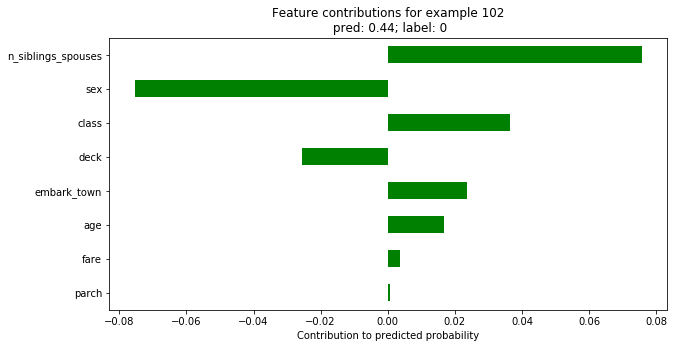

In [9]:
import seaborn as sns  # Make plotting nicer.
sns_colors = sns.color_palette('colorblind')

def plot_dfcs(example_id):
    label, prob = labels[ID], probs[ID]
    example = df_dfc.iloc[ID]  # Choose ith example from evaluation set.
    TOP_N = 8  # View top 8 features.
    sorted_ix = example.abs().sort_values()[-TOP_N:].index
    ax = example[sorted_ix].plot(kind='barh', color='g', figsize=(10,5))
    ax.grid(False, axis='y')

    plt.title('Feature contributions for example {}\n pred: {:1.2f}; label: {}'.format(ID, prob, label))
    plt.xlabel('Contribution to predicted probability')
ID = 102
plot_dfcs(ID)

**??? ** How would you explain the above plot in plain english?

### Prettier plotting
Color codes based on directionality and adds feature values on figure. Please do not worry about the details of the plotting code :)

In [24]:
def plot_example_pretty(example):
    """Boilerplate code for better plotting :)"""
    
    def _get_color(value):
        """To make positive DFCs plot green, negative DFCs plot red."""
        green, red = sns.color_palette()[2:4]
        if value >= 0: return green
        return red


    def _add_feature_values(feature_values, ax):
        """Display feature's values on left of plot."""
        x_coord = ax.get_xlim()[0]
        OFFSET = 0.15
        for y_coord, (feat_name, feat_val) in enumerate(feature_values.items()):
            t = plt.text(x_coord, y_coord - OFFSET, '{}'.format(feat_val), size=12)
            t.set_bbox(dict(facecolor='white', alpha=0.5))
        from matplotlib.font_manager import FontProperties
        font = FontProperties()
        font.set_weight('bold')
        t = plt.text(x_coord, y_coord + 1 - OFFSET, 'feature\nvalue',
        fontproperties=font, size=12)


    TOP_N = 8 # View top 8 features.
    sorted_ix = example.abs().sort_values()[-TOP_N:].index  # Sort by magnitude.
    example = example[sorted_ix]
    colors = example.map(_get_color).tolist()
    ax = example.to_frame().plot(kind='barh',
                          color=[colors],
                          legend=None,
                          alpha=0.75,
                          figsize=(10,6))
    ax.grid(False, axis='y')
    ax.set_yticklabels(ax.get_yticklabels(), size=14)
    _add_feature_values(dfeval.iloc[ID].loc[sorted_ix], ax)
    ax.set_title('Feature contributions for example {}\n pred: {:1.2f}; label: {}'.format(ID, probs[ID], labels[ID]))
    ax.set_xlabel('Contribution to predicted probability', size=14)
    plt.show()
    return ax

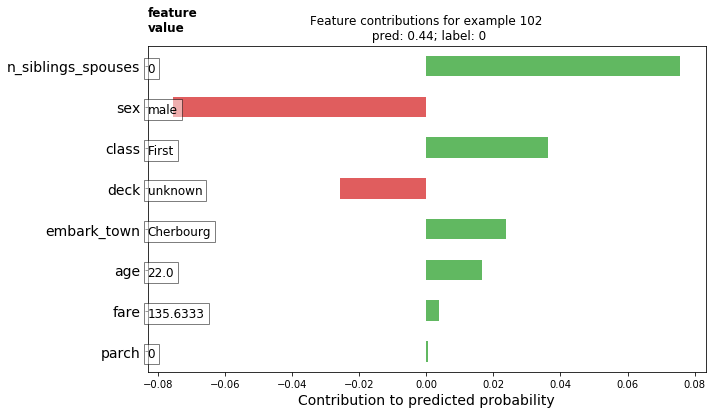

In [25]:
# Plot results.
ID = 102
example = df_dfc.iloc[ID]  # Choose ith example from evaluation set.
ax = plot_example_pretty(example)

## Global feature importances

1. Gain-based feature importances using `est.experimental_feature_importances`
2. Aggregate DFCs using `est.experimental_predict_with_explanations`
3. Permutation importances

Gain-based feature importances measure the loss change when splitting on a particular feature, while permutation feature importances are computed by evaluating model performance on the evaluation set by shuffling each feature one-by-one and attributing the change in model performance to the shuffled feature.

In general, permutation feature importance are preferred to gain-based feature importance, though both methods can be unreliable in situations where potential predictor variables vary in their scale of measurement or their number of categories and when features are correlated ([source](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-9-307)). Check out [this article](http://explained.ai/rf-importance/index.html) for an in-depth overview and great discussion on different feature importance types.

## 1. Gain-based feature importances

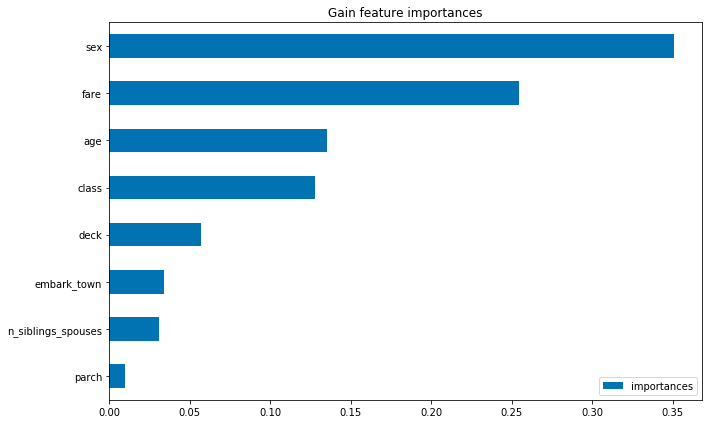

In [12]:
features, importances = est.experimental_feature_importances(normalize=True)
df_imp = pd.DataFrame(importances, columns=['importances'], index=features)
# For plotting purposes. This is not needed in TF 2.0.
df_imp = clean_feature_names(df_imp.T).T.sort_values('importances', ascending=False)

# Visualize importances.
N = 8
ax = df_imp.iloc[0:N][::-1]\
    .plot(kind='barh',
          color=sns_colors[0],
          title='Gain feature importances',
          figsize=(10, 6))
ax.grid(False, axis='y')

plt.tight_layout()

**???** What does the x axis represent? -- A. It represents relative importance. Specifically, the average reduction in loss that occurs when a split occurs on that feature.

**???** Can we completely trust these results and the magnitudes? -- A. The results can be misleading because variables are correlated.

### 2. Average absolute DFCs
We can also average the absolute values of DFCs to understand impact at a global level.

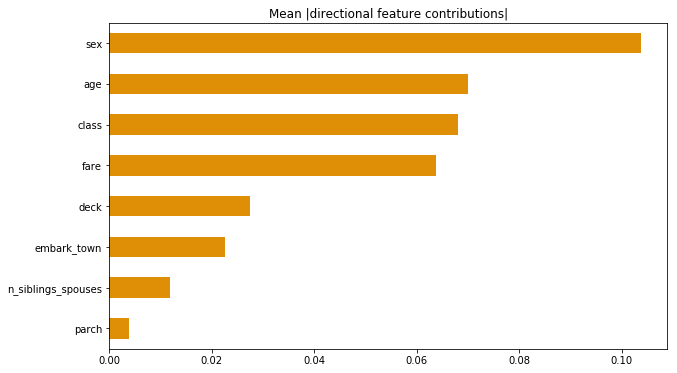

In [13]:
# Plot.
dfc_mean = df_dfc.abs().mean()
sorted_ix = dfc_mean.abs().sort_values()[-8:].index  # Average and sort by absolute.
ax = dfc_mean[sorted_ix].plot(kind='barh',
                       color=sns_colors[1],
                       title='Mean |directional feature contributions|',
                       figsize=(10, 6))
ax.grid(False, axis='y')

We can also see how DFCs vary as a feature value varies.

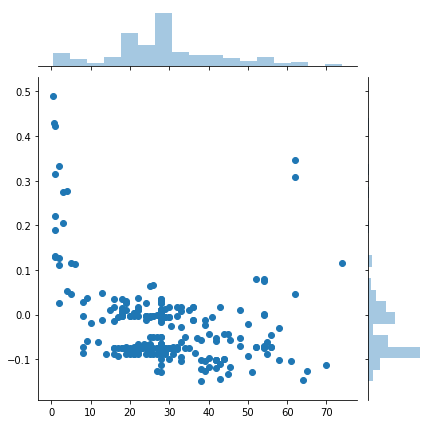

In [14]:
age = pd.Series(df_dfc.age.values, index=dfeval.age.values).sort_index()
sns.jointplot(age.index.values, age.values);

# Visualizing the model's prediction surface

Lets first simulate/create training data using the following formula:


$z=x* e^{-x^2 - y^2}$


Where $z$ is the dependent variable we are trying to predict and $x$ and $y$ are the features.

In [15]:
from numpy.random import uniform, seed
from matplotlib.mlab import griddata

# Create fake data
seed(0)
npts = 5000
x = uniform(-2, 2, npts)
y = uniform(-2, 2, npts)
z = x*np.exp(-x**2 - y**2)

In [16]:
# Prep data for training.
df = pd.DataFrame({'x': x, 'y': y, 'z': z})

xi = np.linspace(-2.0, 2.0, 200),
yi = np.linspace(-2.1, 2.1, 210),
xi,yi = np.meshgrid(xi, yi)

df_predict = pd.DataFrame({
    'x' : xi.flatten(),
    'y' : yi.flatten(),
})
predict_shape = xi.shape

In [17]:
def plot_contour(x, y, z, **kwargs):
  # Grid the data.
  plt.figure(figsize=(10, 8))
  # Contour the gridded data, plotting dots at the nonuniform data points.
  CS = plt.contour(x, y, z, 15, linewidths=0.5, colors='k')
  CS = plt.contourf(x, y, z, 15,
                    vmax=abs(zi).max(), vmin=-abs(zi).max(), cmap='RdBu_r')
  plt.colorbar()  # Draw colorbar.
  # Plot data points.
  plt.xlim(-2, 2)
  plt.ylim(-2, 2)

We can visualize our function:

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: The griddata function was deprecated in version 2.2. Use scipy.interpolate.griddata instead.
  """Entry point for launching an IPython kernel.


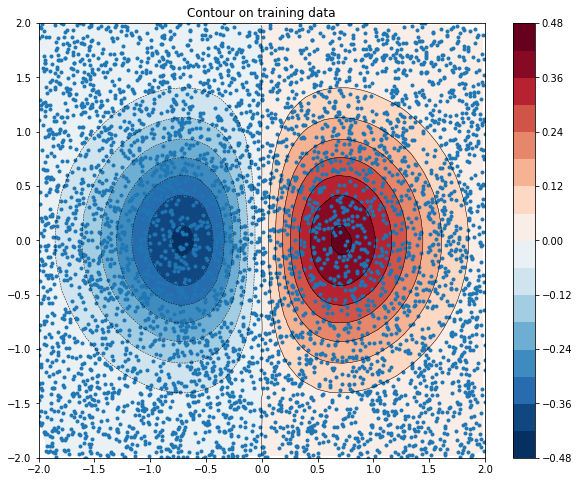

In [18]:
zi = griddata(x, y, z, xi, yi, interp='linear')
plot_contour(xi, yi, zi)
plt.scatter(df.x, df.y, marker='.')
plt.title('Contour on training data')
plt.show()

In [19]:
def predict(est):
  """Predictions from a given estimator."""
  predict_input_fn = lambda: tf.data.Dataset.from_tensors(dict(df_predict))
  preds = np.array([p['predictions'][0] for p in est.predict(predict_input_fn)])
  return preds.reshape(predict_shape)

First let's try to fit a linear model to the data.

In [20]:
fc = [tf.feature_column.numeric_column('x'),
      tf.feature_column.numeric_column('y')]

train_input_fn = make_input_fn(df, df.z)
est = tf.estimator.LinearRegressor(fc)
est.train(train_input_fn, max_steps=500);

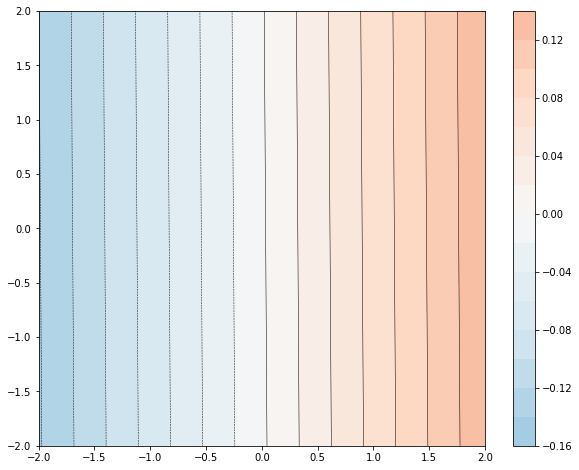

In [21]:
plot_contour(xi, yi, predict(est))

Not very good at all...

**???** Why is the linear model not performing well for this problem? Can you think of how to improve it just using a linear model?

Next let's try to fit a GBDT model to it and try to understand what the model does

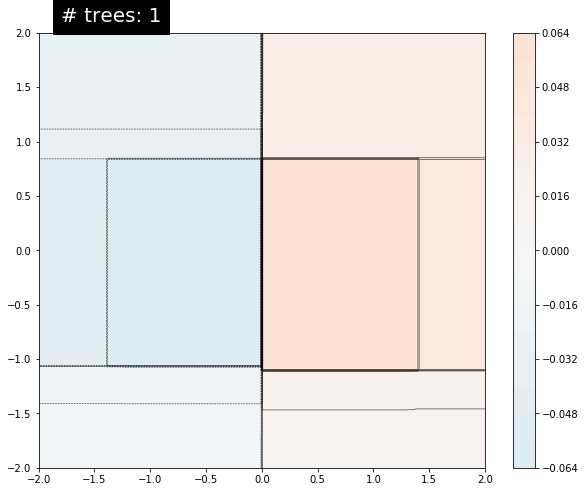

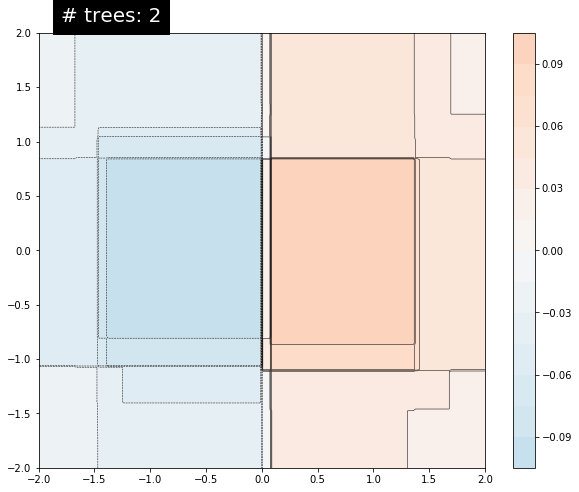

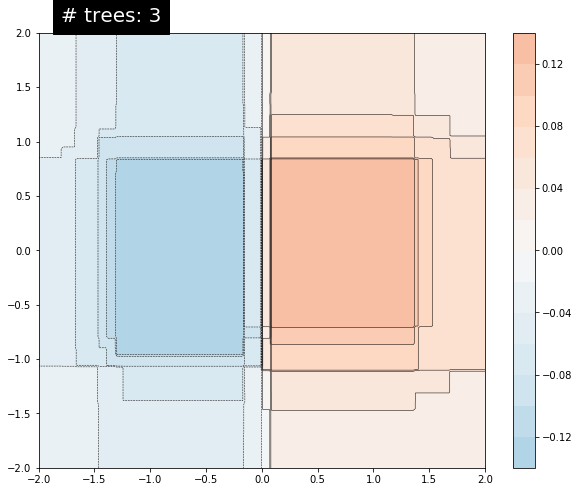

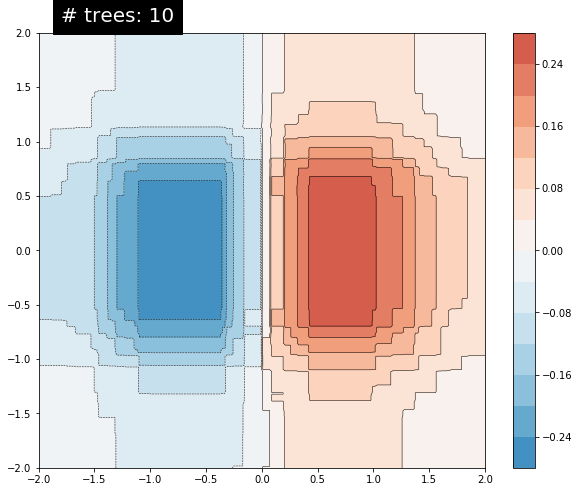

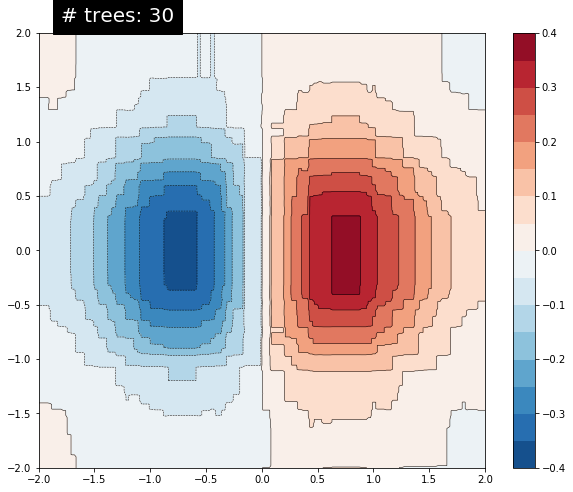

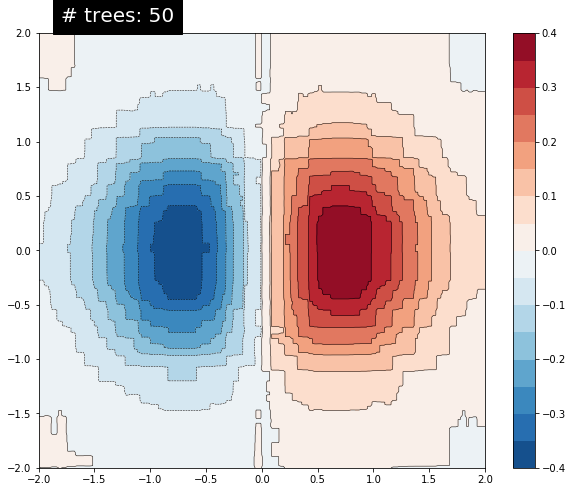

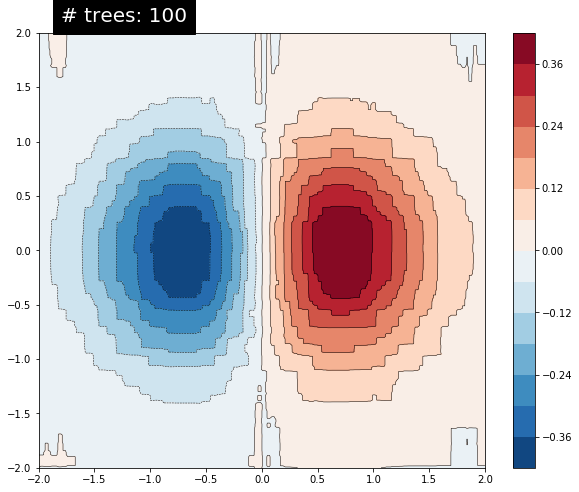

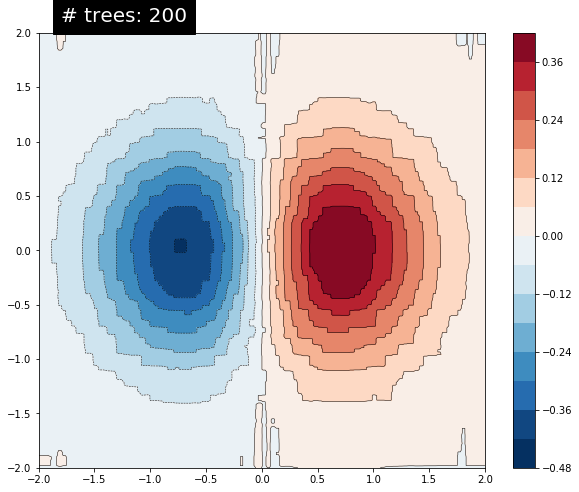

In [22]:
for n_trees in [1,2,3,10,30,50,100,200]:
  est = tf.estimator.BoostedTreesRegressor(fc,
                                          n_batches_per_layer=1,
                                          max_depth=4,
                                          n_trees=n_trees)
  est.train(train_input_fn)
  plot_contour(xi, yi, predict(est))
  plt.text(-1.8, 2.1, '# trees: {}'.format(n_trees), color='w', backgroundcolor='black', size=20)

Copyright 2019 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License